In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Logistic vs. Linear Regression

__Linear regression:__ predict a continuous outcome variable $y$, ie how much money a customer will spend
- Formula for multivariate linear regr relating outcome $y$ to matrix of variables $X$:
$$y=\alpha + \beta X$$

__Logistic regression:__ predict the probability of a categorical outcome (using regression as a classifier)
- Formula for binary logistic regr relating $p$ to a matrix of variables $X$:

$$ln\left(\dfrac p{1-p}\right)=\beta X$$

- $p=$ the probability of $y=1$

- $1-p=$ the probability of $y=0$

- The ratio of $p$ to $1-p$ gives the odds of getting $y=1$

__Example:__ what are the odds for an unfair coin with an 80% probability of heads

- heads = .8/(1-.8) = 4, ie you are 4 times more likely to get heads than tails
- tails = .2/(1-.2) = .25

__Assumptions of logistic regr:__ same assumptions as linear regression
- Linearity of the transformed probabilities and the predictors
- Multivariate normality of the residuals
- Homoscedasticity (variance of residuals is constant across predicted values)
- Low multicollinearity

__Why log?:__ binary outcome (0,1) converted into logged odds because regression requires normally distributed residuals

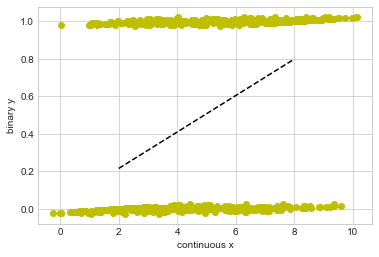

In [2]:
sns.set_style('whitegrid')
#set random seed so results are the same each time code is run
np.random.seed(seed=456613)

#create data
df = pd.DataFrame()
for probs in list(range(2,9)):
    tmp = pd.DataFrame({
        'y': np.random.binomial(1, probs/10, size=(1,100))[0],
        'x': probs
    })
    df = df.append(tmp)
    
x = df['x'] #continuous predictor
bin_y = df['y'] #binary outcome

#calculate linear regression for bot x and bin_y
fit = np.polyfit(x,bin_y,1)

#work as a function to return the predicted value of y
fit_fn = np.poly1d(fit)

#add some noise for graphing purposes
jitter = np.random.randn(700)

#display results
plt.plot(x + jitter, bin_y + jitter / 100, 'yo', x, fit_fn(x), '--k')
plt.xlabel('continuous x')
plt.ylabel('binary y')
plt.show()

Because y only takes two outcomes, relationship between x and y is very non linear. A regression line would fit very poorly to this data.

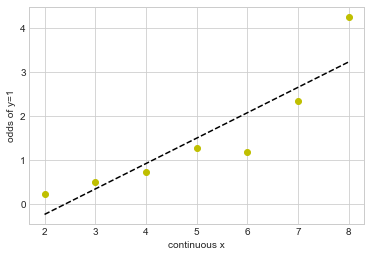

In [3]:
#convert binary values into odds of getting y=1

#unique values in x
xvals = x.unique()

#calculate and store odds
yodds = []
for xi in xvals:
    y1_ct = bin_y[x==xi].sum() #number of trials y=1
    y0_ct = len(bin_y[x==xi]) - y1_ct #number of trials y=0
    yodds.append(y1_ct / y0_ct) #odds of getting y=1 for xi
    
#calculate linear regress for x and yodds
fit = np.polyfit(xvals, yodds, 1)

#work as a function to return the predicted value of yodds
fit_fn = np.poly1d(fit)

#plot results
plt.plot(xvals, yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('continuous x')
plt.ylabel('odds of y=1')
plt.show()

- Get odds by counting number of times y=1 for each value of x, then divide by number of times y=0
- Relationship between odds and coninuous x is still not linear

## Linear vs. Non-Linear Transformations

__Linear transformation:__
- Relationship between original value and transformed value is the same for all values
- Addition, subtraction, multiplication, division

__Non-linear transformation:__
- One unit change to input doesn't create same sized changes in output
- Exponents: the larger the input, the bigger the impact of changing input by 1
- Logarithms: the larger the input, the smaller the impact of changing input by 1 (except for log(1))

## Logarithms

__Logarithm:__
- The power to which the base must be raised to produce the number being logged
- For log base 2: $log(1)=0$ because $2^0 = 1$; $log(2)=1$ because $2^1=2$
- Logs are useful when dealing with data where values become more widely spaced as they increase
- Logging odds can even up the distances between the odds values, leading to a linear relationship with x

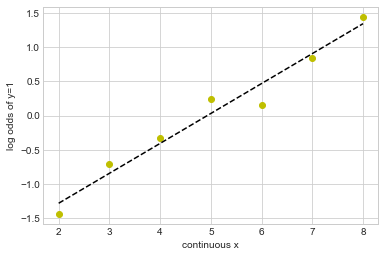

In [4]:
#natural log of odds
ln_yodds = np.log(yodds)

#calculate linear regression for x and yodds
fit = np.polyfit(xvals, ln_yodds, 1)

#function to return predicted value of yodds
fit_fn = np.poly1d(fit)

#plot results
plt.plot(xvals, ln_yodds, 'yo', xvals, fit_fn(xvals), '--k')
plt.xlabel('continuous x')
plt.ylabel('log odds of y=1')
plt.show()

- Now the relationship between odds and x is linear
- Distances of similar magnitude between points

__Interpreting logged odds:__
- Unintuitive interpretation: a 1 unit increase in x leads to a 2.2 log-odds increase in y
- Back-transform log-odds into odds by exponentiation: $(e^logit(p))$

## Fitting a binary logistic model using statsmodels

- Use dataset predicting university admission based on GPA, GRE, and school ranking (1 best 4 worst)
- Use just 'gpa' and 'gre' variables for now

   admit  gre   gpa  rank
0      0  380  3.61     3
1      1  660  3.67     3
2      1  800  4.00     1
3      1  640  3.19     4
4      0  520  2.93     4


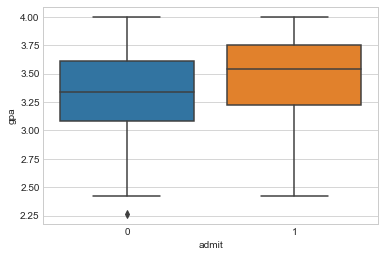

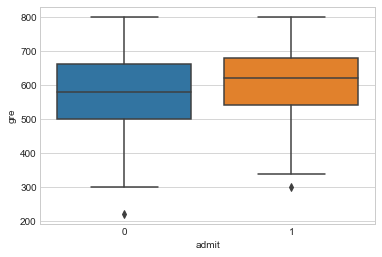

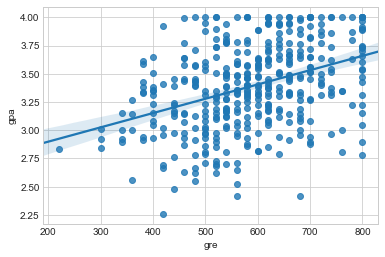

In [5]:
#get data
df = pd.read_csv("https://www.dropbox.com/s/qhf0ocdqb3gh7ni/logistic_regression.csv?dl=1")
print(df.head())

#bivariate relationships of predictors to admissions outcome
sns.boxplot(x='admit', y='gpa', data=df)
plt.show()
sns.boxplot(x='admit', y='gre', data=df)
plt.show()

#relationship between predictors
sns.regplot(x='gre', y='gpa', data=df)
plt.show()

Predictors may add some value but are also correlated with each other

In [6]:
#declare predictors
X_statsmod = df[['gre','gpa']]

#statsmodels formulation requires a column with a constant value 1
#that acts as intercept
X_statsmod['intercept'] = 1

#instantiate and fit model
logit = sm.Logit(df['admit'], X_statsmod)
result = logit.fit()

#workaround for result.summary() error
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

#info about model and coefficients
#but accuracy rate for predictions is missing
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.600430
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      397
Method:                           MLE   Df Model:                            2
Date:                Thu, 10 May 2018   Pseudo R-squ.:                 0.03927
Time:                        12:51:04   Log-Likelihood:                -240.17
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 5.456e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gre            0.0027      0.001      2.544      0.011       0.001       0.005
gpa            0.7547      0.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
#calculate accuracy
#get probability that each row will be admitted
pred_statsmod = result.predict(X_statsmod)

#code admission as 1 if probability is > .5
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

#accuracy table
table = pd.crosstab(df['admit'], pred_y_statsmod)

print('\nAccuracy by admission status')
print(table)
print('\nPercentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))


Accuracy by admission status
col_0    0   1
admit         
0      263  10
1      118   9

Percentage accuracy
0.68


## Binary logistic model using SKLearn

- Statsmodel formulation: fits a standard binary logistic model
- SKLearn logistic regression includes parameter regularization that penalizes extremely large parameters

In [8]:
#declare logistic regression classifier
#parameter regularization coefficient C very large to decrease effectiveness
#of regularization so parameter estimates will be similar to statsmodels
lr = LogisticRegression(C=1e9)
y = df['admit']
X = df[['gpa','gre']]

fit = lr.fit(X,y) #fit model

print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = lr.predict(X)

print('\nAccuracy by admission status')
print(pd.crosstab(pred_y_sklearn,y))
print('\nPercentage accuracy')
print(lr.score(X,y))

Coefficients
[[0.74747563 0.00267019]]
[-4.91157158]

Accuracy by admission status
admit    0    1
row_0          
0      263  118
1       10    9

Percentage accuracy
0.68


## Challenge: optimize models
Play with the models by adding additional features and shrinking the regularization coefficient to see if you can get the accuracy higher than 68%. 

In [19]:
lr2 = LogisticRegression(C=1)
y2 = df['admit']
X2 = df[['gpa','gre','rank']]

fit = lr2.fit(X2,y2)
pred_y2 = lr2.predict(X2)

print('\nPercentage accuracy')
print(lr2.score(X2,y2))


Percentage accuracy
0.71
